# Problem Overview

The University of Pittsburg manages numerous public events each year.  In an effor to drive engagement, the university would like to target specific departments for each event.  The university has provided a list of 400+ event titles and abstracts, and the course descriptions for 150+ majors/departments within the university.  

The goal is to take the event title and description and provide a list of departments that would most applicable to attend.  

## Imports

In [1]:
!pip install gluonNLP
!pip install mxnet

fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
fastai 1.0.59 requires nvidia-ml-py3, which is not installed.
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import boto3
import pickle
import sagemaker
from sagemaker import get_execution_role
import matplotlib.pyplot as plt
from fastai.text import *
import json
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report
from sklearn import preprocessing
from sklearn import decomposition
from sklearn.cluster import KMeans
from collections import Counter
from mxnet import gluon
from mxnet import nd
import gluonnlp as nlp
from sklearn.model_selection import train_test_split

In [3]:
np.set_printoptions(precision=4, suppress=True)

## Data

### Load
Note this data was from a ground truth labeling job that was submitted to a human reviewing work force.  

In [ ]:
# copy data from s3 bucket
!mkdir /tmp/data/

In [ ]:
!aws s3 cp s3://random.datasets.sengstacken/UPittsburg/groundtruth/upittsburg-event-labeling/manifests/output/output.manifest /tmp/data/output.manifest

In [5]:
!ls -lrt /tmp/data 

total 22308
-rw-rw-r-- 1 ec2-user ec2-user     6704 Jan  5 02:56 majors.csv
-rw-rw-r-- 1 ec2-user ec2-user 10171500 Jan  5 03:01 major_to_course_description.csv
-rw-rw-r-- 1 ec2-user ec2-user   176641 Jan  5 03:15 localist_events.json
-rw-rw-r-- 1 ec2-user ec2-user   119476 Jan  6 02:42 events.csv
-rw-rw-r-- 1 ec2-user ec2-user 10830716 Jan  7 15:43 dataset-20200107T094287.manifest
-rw-rw-r-- 1 ec2-user ec2-user   233745 Jan  7 22:54 output.manifest
-rw-rw-r-- 1 ec2-user ec2-user  1281617 Jan 14 23:26 event_attendance_with_major.csv
drwxrwxr-x 3 ec2-user ec2-user     4096 Jan 14 23:27 groundtruth


In [6]:
# read in the data from output.manifest
temp = []
for line in open('/tmp/data/output.manifest', 'r'):
    temp.append(json.loads(line))

In [7]:
# grab data of interest from the json data, create a dataframe
temp2 = []
for l in temp:
    t = [l['source'], l['upittsburg-event-labeling'], l['upittsburg-event-labeling-metadata']['class-name']]
    temp2.append(t)

data_df = pd.DataFrame(temp2,columns=['text','class_int','class'])

In [8]:
data_df.head()

,text,class_int,class
0,Market-Proof Your Retirement: TIAA Live Webina...,9,Finance
1,Paying Yourself: Income Options in Retirement:...,9,Finance
2,"""Demystifying Life Insurance: TIAA Live Webina...",9,Finance
3,"""Halfway There: A Retirement Checkpoint: TIAA ...",9,Finance
4,"""Planning for Diminished Capacity and Illness:...",4,Biology


In [9]:
data_df['class'].unique()

array(['Finance', 'Biology', 'Music / Theatre', 'Computer Science', 'Business', 'Unknown', 'Medicine',
       'General Arts and Sciences', 'Chemistry', 'Public Heath', 'History / Political Science', 'Languages',
       'Social Work', 'Law', 'Nursing', 'Pharmacy'], dtype=object)

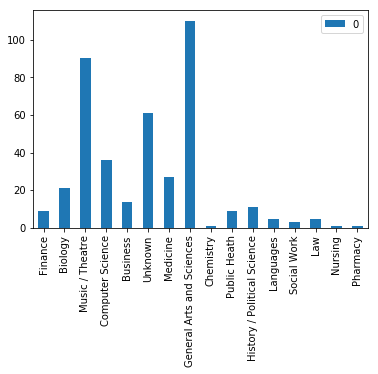

In [10]:
# check distribution of labels 
label_counts = Counter(data_df['class'].values)
df = pd.DataFrame.from_dict(label_counts, orient='index')
df.plot(kind='bar');

In [11]:
# how long is each event description?
lens = data_df['class'].str.len()
lens.mean(), lens.std(), lens.max()

(15.254950495049505, 7.321869769438688, 27)

Text(0.5, 0, 'event description string length')

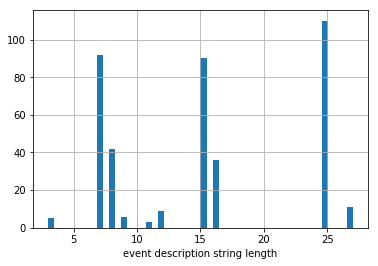

In [12]:
lens.hist(bins=50);
plt.xlabel('event description string length')

### Data Split

In [13]:
events = data_df['text'].values
labels = data_df['class'].values

In [14]:
le = preprocessing.LabelEncoder()
num_labels = le.fit_transform(labels)

In [15]:
classes = le.classes_

In [16]:
num_labels

array([4, 4, 4, 4, ..., 3, 3, 3, 5])

In [17]:
X_train, X_test, y_train, y_test = train_test_split(events, num_labels, test_size=0.2, random_state = 42)

## Analysis

The data is now cleaned, loaded, split and ready for analysis.  The general framework of the analysis will be to convert the descriptions into vectors and then train a classifier to predict the class from the vectors.  We will investigate the following approaches to generating vectors from the events:

* TF
* TF-IDF
* TF-IDF with stop words removed
* GloVe pretrained vectors

Using the vectorized representation of the events we will use the following approaches for classification:

* Naive Bayes
* Support Vector Machine
* Decision Tree
* Neural Network

### TF-IDF

TF-IDF is a bag of words approach used in natural langauge processing.  The approach produces a sparce matrix that is number of documents by the number of terms.  The values are proportional to the number of occurances of the terms in the document and inversly proportional to the number of occurances in the corpus.

TF = (# occurrences of term t in document) / (# of words in documents)

IDF = log(# of documents / # documents with term t in it)


In [18]:
# training dataset
stop_words = 'english'  #'english' or None
vectorizer = CountVectorizer(stop_words=stop_words)
doc_x_train = vectorizer.fit_transform(X_train)
transformer = TfidfTransformer()
tfidf_x_train = transformer.fit_transform(doc_x_train)

In [ ]:

import re, string
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')
def tokenize(s): return re_tok.sub(r' \1 ', s).split()

In [ ]:
vectorizer = TfidfVectorizer(ngram_range=(1,2), tokenizer=tokenize,
               min_df=3, max_df=0.9, strip_accents='unicode', use_idf=1,
               smooth_idf=1, sublinear_tf=1 )

tfidf_x_train = vec.fit_transform(X_train)


In [19]:
# testing dataset
doc_x_test = vectorizer.transform(X_test)
tfidf_x_test = transformer.transform(doc_x_test)

In [20]:
# optional, check stop words and vocab
vectorizer.stop_words_
vectorizer.vocabulary_;

In [21]:
vocab = np.array(vectorizer.get_feature_names())
print(len(vocab))
print(len(vectorizer.vocabulary_))

3421
3421


### Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

In [23]:
clf = MultinomialNB()
clf.fit(tfidf_x_train, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [24]:
y_pred = clf.predict(tfidf_x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes[list(set(y_test))]))

accuracy 0.37037037037037035
                             precision    recall  f1-score   support

                    Biology       0.00      0.00      0.00         2
                   Business       0.00      0.00      0.00         1
                  Chemistry       0.00      0.00      0.00         1
           Computer Science       0.00      0.00      0.00         9
                    Finance       0.00      0.00      0.00         3
  General Arts and Sciences       0.31      0.95      0.47        22
History / Political Science       0.00      0.00      0.00         3
                  Languages       0.00      0.00      0.00         2
                        Law       0.00      0.00      0.00         1
                   Medicine       0.00      0.00      0.00         4
            Music / Theatre       0.86      0.26      0.40        23
                    Unknown       0.50      0.30      0.37        10

                  micro avg       0.37      0.37      0.37        81
   

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### SVM

In [25]:
from sklearn.linear_model import SGDClassifier
clf = SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42,max_iter=5, tol=None)
clf.fit(tfidf_x_train, y_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:183: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If max_iter is set but tol is left unset, the default value for tol in 0.19 and 0.20 will be None (which is equivalent to -infinity, so it has no effect) but will change in 0.21 to 1e-3. Specify tol to silence this warning.
  FutureWarning)


SGDClassifier(alpha=0.001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [26]:
y_pred = clf.predict(tfidf_x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes[list(set(y_test))]))

accuracy 0.35802469135802467
                             precision    recall  f1-score   support

                    Biology       0.00      0.00      0.00         2
                   Business       0.00      0.00      0.00         1
                  Chemistry       0.00      0.00      0.00         1
           Computer Science       0.60      0.33      0.43         9
                    Finance       0.75      1.00      0.86         3
  General Arts and Sciences       0.30      0.32      0.31        22
History / Political Science       0.50      0.33      0.40         3
                  Languages       0.00      0.00      0.00         2
                        Law       0.00      0.00      0.00         1
                   Medicine       0.33      0.50      0.40         4
            Music / Theatre       0.56      0.39      0.46        23
                    Unknown       0.27      0.40      0.32        10

                  micro avg       0.36      0.36      0.36        81
   

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Logistic Regression

In [27]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(n_jobs=1, C=1e5)
clf.fit(tfidf_x_train, y_train)

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=1, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [28]:
y_pred = clf.predict(tfidf_x_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=classes[list(set(y_test))]))

accuracy 0.41975308641975306
                             precision    recall  f1-score   support

                    Biology       0.00      0.00      0.00         2
                   Business       0.00      0.00      0.00         1
                  Chemistry       0.00      0.00      0.00         1
           Computer Science       0.75      0.33      0.46         9
                    Finance       0.75      1.00      0.86         3
  General Arts and Sciences       0.38      0.50      0.43        22
History / Political Science       0.50      0.33      0.40         3
                  Languages       0.00      0.00      0.00         2
                        Law       0.00      0.00      0.00         1
                   Medicine       0.33      0.50      0.40         4
            Music / Theatre       0.62      0.43      0.51        23
                    Unknown       0.33      0.40      0.36        10

                  micro avg       0.42      0.42      0.42        81
   

/home/ec2-user/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Word Embeddings

The GloVE (Global Vectors) pretrained model is one example of pretrained word vectors.  This pretrained model was developed as an open source project at Stanford.  The models was trained on 6B tokens from Wikipedia and Gigaword datasets.

Glove is available at http://nlp.stanford.edu/data/glove.6B.zip  To download and unzip the files from the command line, you can run:

In [ ]:
# tokenize
test = ["\"hello world, how are you \n thanks for your input!! \n","one and Two, here we go?"]
tokenized = tokenize(" ".join(test))

In [ ]:
counter = nlp.data.count_tokens(tokenized)

In [ ]:
counter

In [ ]:
vocab = nlp.Vocab(counter)

In [ ]:
for word in vocab.idx_to_token:
    print(word)

In [ ]:
print(vocab.token_to_idx["world"])

In [ ]:
print(vocab.idx_to_token[20])

In [ ]:
# load word embedding
fasttext_simple = nlp.embedding.create('fasttext', source='wiki.simple')

In [ ]:
# attach word embedding to vocab
vocab.set_embedding(fasttext_simple)

In [ ]:
vocab.embedding['world'][:5]

## Comparison

## Links / References:

* https://github.com/fastai/word-embeddings-workshop/blob/master/Word%20Embeddings.ipynb
* https://nlp.town/blog/sentence-similarity/
* https://www.kaggle.com/jhoward/nb-svm-strong-linear-baseline